In [45]:
import pandas as pd
df = pd.DataFrame()
import csv
from scipy.stats import zscore
import numpy as np

## Extract data from raw text wifi log file

In [46]:
#Create csv file
jan1_csv = open('jan1.csv', 'w')
#Column names
col_name = ['building', 'date', 'month', 'time', 'device_count']
csv_writer = csv.DictWriter(jan1_csv, fieldnames=col_name)
csv_writer.writeheader()


39

In [47]:
def processLine(buildingName='UREC', wifi_log=''):
    count = 0
    for log_line in wifi_log:
        if buildingName in log_line:
            # process device count
            if '501080' in log_line or '501105' in log_line or '501106' in log_line:
                count += 0
            if '501093' in log_line:
                count += 1
            # Slice the line to get the date and time
            atr = log_line.split(' ')
            # Extract the data
            month = atr[0]
            date = atr[1]
            time = atr[2]
            building = buildingName
            # add data to csv file
            csv_writer.writerow({'building': building, 'date': date, 'month': month, 'time': time, 'device_count': count})


In [48]:
wifi_log = open('wireless_09-21-2021.log', 'r')
# # print first ten lines in the file
# for i in range(3):
#     print(wifi_log.readline())

# loop through each line in the file
processLine(wifi_log=wifi_log)

# close the file
wifi_log.close()


# Preprocess the raw csv to something meaningful (non-scalable)

### Look at the dataframe

In [49]:
# Look look at the data
# convert jan1.csv to dataframe
df = pd.read_csv('jan1.csv')
df

,building,date,month,time,device_count
0,UREC,21,Sep,00:00:11,1
1,UREC,21,Sep,00:00:11,1
2,UREC,21,Sep,00:00:11,1
3,UREC,21,Sep,00:00:11,1
4,UREC,21,Sep,00:00:11,1
...,...,...,...,...,...
1057200,UREC,21,Sep,23:59:47,172702
1057201,UREC,21,Sep,23:59:47,172702
1057202,UREC,21,Sep,23:59:47,172702
1057203,UREC,21,Sep,23:59:59,172702


### Process the time columns into a timestamp column

In [50]:
# convert time to datetime
df['timestamp'] = pd.to_datetime(df['time'])
# get type of time column
print('timestamp column type: ', df['timestamp'].dtype)
# diplay from time 00:00:00 to 00:00:59
df1 = df.loc[(df['timestamp'] >= '17:00:00') & (df['timestamp'] <= '18:00:00')]
# drop date and month column
df1 = df1.drop(['date', 'month', 'time'], axis=1)
df1


timestamp column type:  datetime64[ns]


,building,device_count,timestamp
592572,UREC,97763,2022-11-07 17:00:00
592573,UREC,97763,2022-11-07 17:00:00
592574,UREC,97763,2022-11-07 17:00:00
592575,UREC,97763,2022-11-07 17:00:00
592576,UREC,97764,2022-11-07 17:00:00
...,...,...,...
690366,UREC,113779,2022-11-07 18:00:00
690367,UREC,113780,2022-11-07 18:00:00
690368,UREC,113780,2022-11-07 18:00:00
690369,UREC,113780,2022-11-07 18:00:00


In [51]:
count = 0
dfTrim = pd.DataFrame()

while count < 24:
    startTime = ''
    endTime = ''

    if count < 10:
        startTime = pd.to_datetime('0' + str(count) + ':00:00')
        endTime = pd.to_datetime('0' + str(count) + ':59:59')
    else:
        startTime = pd.to_datetime(str(count) + ':00:00')
        endTime = pd.to_datetime(str(count) + ':59:59')

    df1 = df.loc[(df['timestamp'] >= startTime) & (df['timestamp'] <= endTime )]
    dfTrim = dfTrim.append(df1.iloc[1])
    count += 1


dfTrim = dfTrim.reset_index()
dfTrim


,index,building,date,device_count,month,time,timestamp
0,1,UREC,21.0,1.0,Sep,00:00:11,2022-11-07 00:00:11
1,1500,UREC,21.0,250.0,Sep,01:00:08,2022-11-07 01:00:08
2,3258,UREC,21.0,542.0,Sep,02:00:03,2022-11-07 02:00:03
3,3788,UREC,21.0,629.0,Sep,03:00:02,2022-11-07 03:00:02
4,4223,UREC,21.0,700.0,Sep,04:00:23,2022-11-07 04:00:23
5,4549,UREC,21.0,752.0,Sep,05:00:09,2022-11-07 05:00:09
6,6763,UREC,21.0,1121.0,Sep,06:00:02,2022-11-07 06:00:02
7,23777,UREC,21.0,3795.0,Sep,07:00:00,2022-11-07 07:00:00
8,52630,UREC,21.0,8342.0,Sep,08:00:00,2022-11-07 08:00:00
9,93892,UREC,21.0,15083.0,Sep,09:00:00,2022-11-07 09:00:00


In [52]:
dfTrim['traffic_diff'] = dfTrim['device_count'].diff(periods=1)
dfTrim

,index,building,date,device_count,month,time,timestamp,traffic_diff
0,1,UREC,21.0,1.0,Sep,00:00:11,2022-11-07 00:00:11,NaN
1,1500,UREC,21.0,250.0,Sep,01:00:08,2022-11-07 01:00:08,249.0
2,3258,UREC,21.0,542.0,Sep,02:00:03,2022-11-07 02:00:03,292.0
3,3788,UREC,21.0,629.0,Sep,03:00:02,2022-11-07 03:00:02,87.0
4,4223,UREC,21.0,700.0,Sep,04:00:23,2022-11-07 04:00:23,71.0
5,4549,UREC,21.0,752.0,Sep,05:00:09,2022-11-07 05:00:09,52.0
6,6763,UREC,21.0,1121.0,Sep,06:00:02,2022-11-07 06:00:02,369.0
7,23777,UREC,21.0,3795.0,Sep,07:00:00,2022-11-07 07:00:00,2674.0
8,52630,UREC,21.0,8342.0,Sep,08:00:00,2022-11-07 08:00:00,4547.0
9,93892,UREC,21.0,15083.0,Sep,09:00:00,2022-11-07 09:00:00,6741.0


In [54]:
dfTrim['traffic_diff'] = dfTrim['traffic_diff'].replace(np.nan, 0)
dfTrim['traffic_diff_zscore'] = zscore(dfTrim['traffic_diff'])
print(dfTrim['traffic_diff'].dtype)
dfTrim

float64


,index,building,date,device_count,month,time,timestamp,traffic_diff,traffic_diff_zscore
0,1,UREC,21.0,1.0,Sep,00:00:11,2022-11-07 00:00:11,0.0,-1.305168
1,1500,UREC,21.0,250.0,Sep,01:00:08,2022-11-07 01:00:08,249.0,-1.259743
2,3258,UREC,21.0,542.0,Sep,02:00:03,2022-11-07 02:00:03,292.0,-1.251898
3,3788,UREC,21.0,629.0,Sep,03:00:02,2022-11-07 03:00:02,87.0,-1.289297
4,4223,UREC,21.0,700.0,Sep,04:00:23,2022-11-07 04:00:23,71.0,-1.292216
5,4549,UREC,21.0,752.0,Sep,05:00:09,2022-11-07 05:00:09,52.0,-1.295682
6,6763,UREC,21.0,1121.0,Sep,06:00:02,2022-11-07 06:00:02,369.0,-1.237851
7,23777,UREC,21.0,3795.0,Sep,07:00:00,2022-11-07 07:00:00,2674.0,-0.817346
8,52630,UREC,21.0,8342.0,Sep,08:00:00,2022-11-07 08:00:00,4547.0,-0.475652
9,93892,UREC,21.0,15083.0,Sep,09:00:00,2022-11-07 09:00:00,6741.0,-0.075397


In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

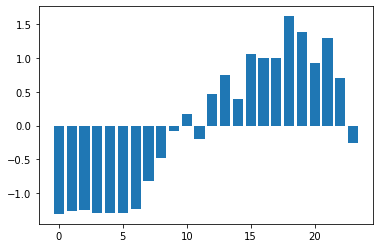

In [57]:
# bar graph
plt.bar(dfTrim.index, dfTrim['traffic_diff_zscore'])
plt.show()

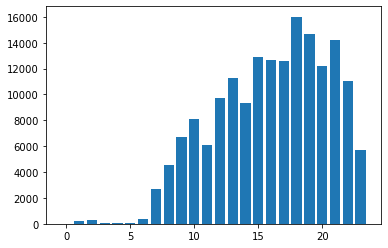

In [58]:
# bar graph
plt.bar(dfTrim.index, dfTrim['traffic_diff'])
plt.show()

In [ ]:
# # create heat map of the device count with time
# sns.heatmap(df1.pivot('timestamp','device_count'), cmap="crest")
# # show the plot
# plot.show()

/var/folders/6j/nsk0gz292l5d1myql08vqrkm0000gn/T/ipykernel_48858/2689085880.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(df1.pivot('timestamp','device_count'), cmap="crest")


ValueError: Index contains duplicate entries, cannot reshape